In [1]:
import pandas as pd 
import numpy as np
import os
import faiss
import cv2
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops
import warnings
warnings.simplefilter("ignore")

### HISTOGRAMAS DE TEXTURA FEATURE SELECTOR

In [2]:
paths_db = pd.read_csv("database\db.csv", index_col=0)
paths = paths_db["path"].values.tolist()

In [3]:
def get_glcm_features(image_path, distances=[1], angles=[0]):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Calcular la GLCM
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    # Extraer características: contraste, correlación, energía y homogeneidad
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    
    # Combinar todas las características en un solo vector
    features = np.hstack([contrast, correlation, energy, homogeneity])
    return features

In [4]:
all_features = []
dimension = 256
for path in paths:
    features = get_glcm_features(path)
    all_features.append(features)

all_features[2]

array([7.51221351e+02, 9.01536099e-01, 3.34106833e-02, 2.59675420e-01])

In [5]:
vectores = np.array(all_features).astype(np.float32)
dimension = vectores[0].shape[0]


index = faiss.IndexFlatL2(dimension)

faiss.normalize_L2(vectores)

index.add(vectores)

# Guardar el índice en la carpeta database
faiss.write_index(index, "database\histograms_texture.index")

In [6]:
#Buscar 5 imagenes  similares
def buscar_imagenes_similares(image_path, index, k=5):
    features = get_glcm_features(image_path)
    features = np.array([features]).astype(np.float32)
    faiss.normalize_L2(features)
    D, I = index.search(features, k)
    return I.flatten()

image_path = paths[0]
similar_images = buscar_imagenes_similares(image_path, index)
similar_images

array([  0, 913, 761, 160, 300], dtype=int64)

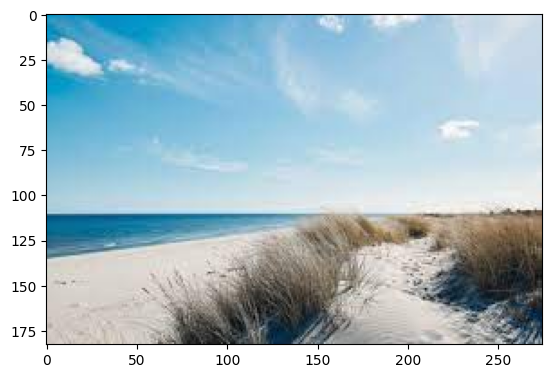

In [10]:
img_test = cv2.imread(image_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
plt.imshow( img_test)


archive\Training Data\Coast\Coast-Train (1).jpeg


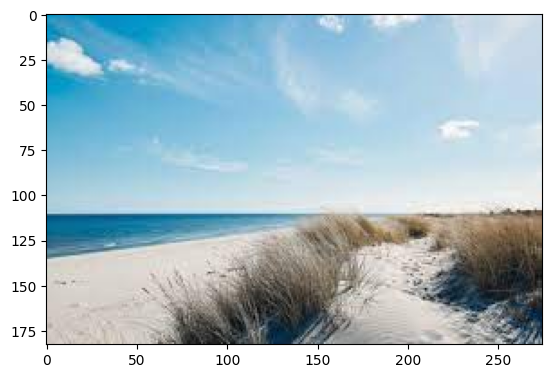

archive\Training Data\Mountain\Mountain (3089).jpeg


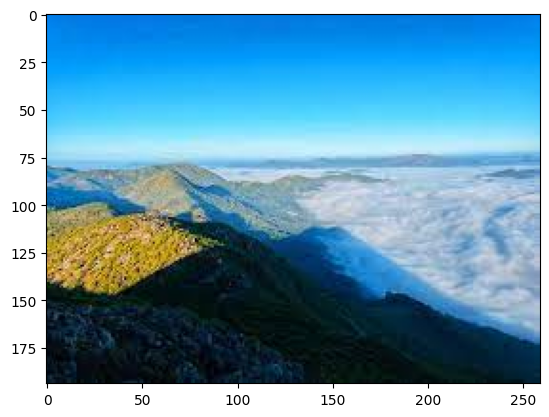

archive\Training Data\Glacier\Glacier-Train (1143).jpeg


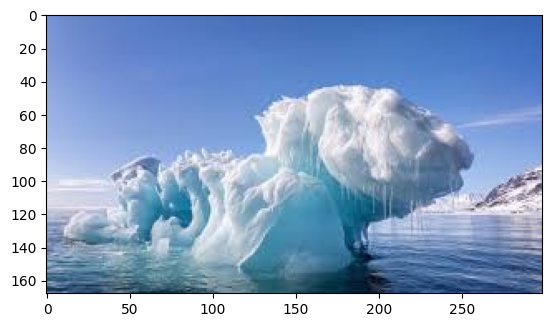

archive\Training Data\Coast\Coast-Train (1142).jpeg


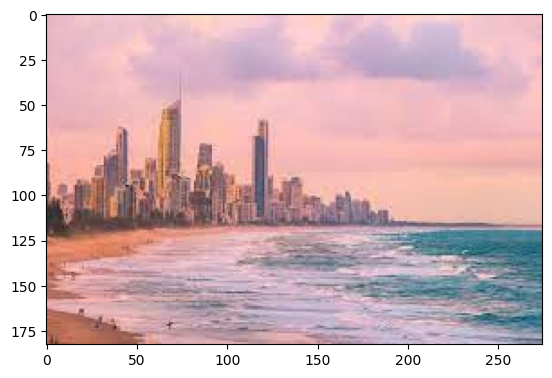

archive\Training Data\Desert\Desert-Train (1089).jpeg


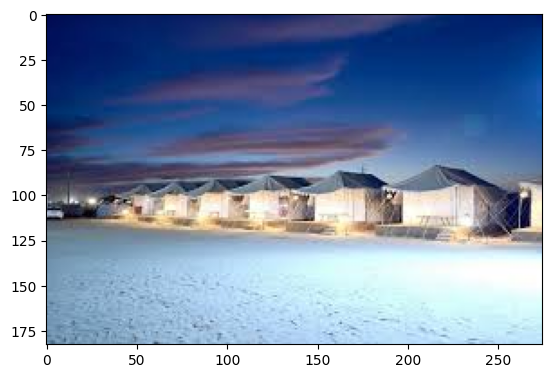

In [12]:
#con los indices saca el path y muestra las imagenes
for i in similar_images:
    print(paths[i])
    img = cv2.imread(paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()